In [54]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


from mpl_toolkits.axes_grid1 import make_axes_locatable
from SNN.models import SNNLayer
from SNN.utils import temporal_encode

In [55]:
device = torch.device("cuda")

In [56]:
class BinarizeTransform:
    """
    A class to binarize the input MNIST data.
    """
    def __call__(self, img):
        # Values are between 0 and 1 so I have binarized with threshold of 0.5
        return (img>0.5).float()

image_size = 14
number_of_devcies = image_size **2 //4

# Transform to be applied on to the data immediately after loading from location.
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    BinarizeTransform()
])

# Load and transform MNIST data
mnist_data_train = datasets.MNIST(root="data/MNIST", train=True, download=True, transform=transform)
mnist_data_test = datasets.MNIST(root="data/MNIST", train=False, download=True, transform=transform)
# mnist_data_train = datasets.FashionMNIST(root="data/MNIST", train=True, download=True, transform=transform)
# mnist_data_test = datasets.FashionMNIST(root="data/MNIST", train=False, download=True, transform=transform)
# train_size = int(0.9 * len(mnist_data_train))       # Size of the train split
# val_size = len(mnist_data_train) - train_size       # Size of the validation split



In [57]:
reservoir_states = pd.read_excel("./data/reservoir_yasir.xlsx")

In [58]:
reservoir_states['drain current'].to_dict()

{0: 1.76717e-11,
 1: 1.62311e-08,
 2: 1.57451e-08,
 3: 1.12498e-07,
 4: 6.54462e-09,
 5: 8.25025e-08,
 6: 6.63099e-08,
 7: 1.98421e-07,
 8: 1.43578e-08,
 9: 1.08757e-07,
 10: 8.08319e-08,
 11: 2.16507e-07,
 12: 5.91702e-08,
 13: 1.89168e-07,
 14: 1.14273e-07,
 15: 2.52958e-07}

In [59]:
class CustomDataset(Dataset):
    def __init__(self, mnist_data, reservoir_states, number_of_devices=196):
        super().__init__()
        self.processed_data = []
        self.labels = []

        if mnist_data.transform is not None:
            # data = torch.stack([mnist_data.transform(img) for img in mnist_data.data])
            data = mnist_data.transform(mnist_data.data)


        data = data.reshape((data.shape[0], number_of_devices, 4))
        data = (
            data[:, :, 0]*8+
            data[:, :, 1]*4+
            data[:, :, 2]*2+
            data[:, :, 3]
        )

        mapping_dict = reservoir_states['drain current'].to_dict()

        self.processed_data = torch.tensor(np.vectorize(mapping_dict.get)(data)).to(device) * 1e7
        self.labels = torch.tensor(mnist_data.targets).to(device)

    def __len__(self):
        return self.processed_data.shape[0]
    
    def __getitem__(self, index):
        return self.processed_data[index], self.labels[index]

# ds = CustomDataset(mnist_data_train, reservoir_states, 196)



In [60]:
class ResourceRichReadoutLayer(nn.Module):
    def __init__(self, input_size: int):
        super(ResourceRichReadoutLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Norm after first FC layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout with 30% probability

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Norm after second FC layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout

        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        self.act = F.gelu

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)  # Output layer (logits)
        return x


class ResourceConstraintedReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ResourceConstraintedReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 10)
        self.activation = nn.functional.leaky_relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x

In [61]:
mnist_data_train.transform(mnist_data_train.data).shape

torch.Size([60000, 14, 14])

In [62]:

BATCH_SIZE = 1024


train_dataset = CustomDataset(mnist_data_train, reservoir_states, number_of_devcies)
test_dataset = CustomDataset(mnist_data_test, reservoir_states, number_of_devcies)


train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



C:\Users\adith\AppData\Local\Temp\ipykernel_5704\3161175913.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets).to(device)


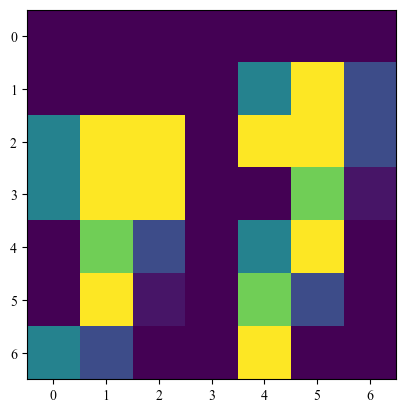

In [63]:
img = train_dataset[123][0].reshape((image_size//2, image_size//2)).cpu()

plt.imshow(img)

In [64]:

EPOCHS = 300
learning_rate = 0.0005
# learning_rate = 1e-3

model = ResourceRichReadoutLayer(number_of_devcies).to(device=device)
# model = ResourceConstraintedReadoutLayer(number_of_devcies).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
precision = Precision(task="multiclass", num_classes=10, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=10, average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=10).to(device)


In [65]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
        val_accuracy.append(accuracy.compute().item())
        val_precision.append(precision.compute().item())
        val_recall.append(recall.compute().item())
        val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [1/300], Loss: 1.2299 Validation - Accuracy: 0.7181 Precision: 0.7151  Recall: 0.7121 F1 Score: 0.7085
Epoch [2/300], Loss: 0.8127 Validation - Accuracy: 0.7918 Precision: 0.7906  Recall: 0.7878 F1 Score: 0.7872
Epoch [3/300], Loss: 0.6729 Validation - Accuracy: 0.8167 Precision: 0.8150  Recall: 0.8138 F1 Score: 0.8135
Epoch [4/300], Loss: 0.5755 Validation - Accuracy: 0.8329 Precision: 0.8317  Recall: 0.8306 F1 Score: 0.8306
Epoch [5/300], Loss: 0.5588 Validation - Accuracy: 0.8404 Precision: 0.8395  Recall: 0.8380 F1 Score: 0.8381
Epoch [6/300], Loss: 0.4698 Validation - Accuracy: 0.8485 Precision: 0.8472  Recall: 0.8466 F1 Score: 0.8467
Epoch [7/300], Loss: 0.4946 Validation - Accuracy: 0.8507 Precision: 0.8494  Recall: 0.8486 F1 Score: 0.8486
Epoch [8/300], Loss: 0.4675 Validation - Accuracy: 0.8563 Precision: 0.8551  Recall: 0.8543 F1 Score: 0.8543
Epoch [9/300], Loss: 0.4566 Validation - Accuracy: 0.8580 Precision: 0.8574  Recall: 0.8558 F1 Score: 0.8561
Epoch [10/300], Los

In [66]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.4f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1*100:.4f}')

        

Test Accuracy: 92.5100%
Test Precision: 92.4837%
Test Recall: 92.4174%
Test F1 Score: 92.4293


C:\Users\adith\AppData\Local\Temp\ipykernel_5704\2454491615.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


In [67]:
x = np.argmax(val_fscore)
print(f"Accuracy = {val_accuracy[x]:.5f}\nPrecision = {val_precision[x]:.5f}\nRecall = {val_recall[x]:.5f}\nF-score = {val_fscore[x]:.5f}")
# print(val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

Accuracy = 0.90690
Precision = 0.90645
Recall = 0.90590
F-score = 0.90598


Accuracy = 0.95970
Precision = 0.95941
Recall = 0.95932
F-score = 0.95936

Test Accuracy: 97.19%
Test Precision: 97.1718%
Test Recall: 97.1627%
Test F1 Score: 0.9717

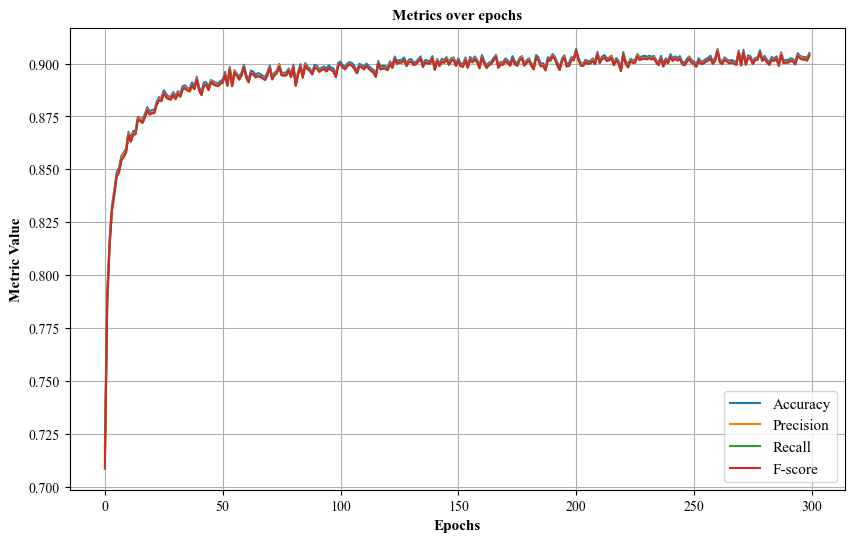

In [68]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], val_accuracy, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], val_precision, label='Precision')
plt.plot([i for i in range(len(val_recall))], val_recall, label='Recall')
plt.plot([i for i in range(len(val_fscore))], val_fscore, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()

In [69]:
metrics_df = pd.DataFrame({
    "Accuracy":val_accuracy,
    "Precision":val_precision,
    "Recall":val_recall,
    "F-score":val_fscore
})

In [70]:
if isinstance(model, ResourceRichReadoutLayer):
    model_type = "no_resource_constraint"
elif isinstance(model, ResourceConstraintedReadoutLayer):
    model_type = "resource_constraint"
else:
    raise TypeError("ARMAGEDDON HERE IN MODEL TYPE")

if isinstance(mnist_data_train, datasets.MNIST):
    if image_size == 28:
        metrics_path = f"data/RC_yasir_metrics/MNIST/RC_{model_type}/"
    elif image_size == 20:
        metrics_path = f"data/RC_yasir_metrics/Reduced_mnist_20x20/RC_{model_type}/"
    elif image_size == 14:
        metrics_path = f"data/RC_yasir_metrics/Reduced_mnist_14x14/RC_{model_type}/"
    else:
        raise TypeError("ARMAGEDDON IN FILE PATH")
else:
    raise TypeError("ARMAGEDDON IN DATASET CLASS")

print(metrics_path)

data/RC_yasir_metrics/Reduced_mnist_14x14/RC_no_resource_constraint/


In [71]:
# metrics_df.to_excel(metrics_path + "metrics.xlsx")

In [72]:
test_confusion_matrix

tensor([[ 943,    0,    2,    3,    6,    2,    9,    2,   12,    1],
        [   1, 1103,    5,    3,    0,    1,    7,    1,   14,    0],
        [   4,    3,  983,   16,    1,    1,    2,    6,   16,    0],
        [   4,    1,   20,  900,    0,   29,    2,    7,   40,    7],
        [   4,    1,    6,    0,  906,    1,    6,    4,    4,   50],
        [   7,    1,    0,   35,    3,  780,   16,    2,   44,    4],
        [   8,    4,    2,    0,    6,    5,  929,    0,    4,    0],
        [   1,    4,   14,    6,   12,    1,    0,  918,    2,   70],
        [  13,    2,    4,   26,    5,   22,    5,   10,  878,    9],
        [   3,    5,    2,   12,   24,    9,    0,   33,   10,  911]],
       device='cuda:0')

In [73]:

confusion_matrix_df = pd.DataFrame(test_confusion_matrix.cpu().numpy(), index=mnist_data_train.classes, columns=mnist_data_train.classes)

# confusion_matrix_df.to_excel(metrics_path + "confusion_matrix.xlsx")